In [1]:
#  conda install -c conda-forge opencv 
import cv2
import glob, os
from PIL import Image, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from scipy import ndimage
from skimage import measure

In [2]:
DIR = '/home/pawel/Documents/AnacondaProjects/ImageSegmentation/bees/'

Splitting mp4 file into frames.

In [3]:
def generate_frames():
    vidcap = cv2.VideoCapture(DIR + 'Capt2.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        cv2.imwrite(DIR + "frames/frame%d.jpg" % count, image)     # save frame as JPEG file
        if cv2.waitKey(10) == 27:                     # exit if Escape is hit
            break
        count += 1

In [ ]:
# Data analysis

In [5]:
chosen_frames = []
other_images = []

Loading prepared images.

In [6]:
os.chdir(DIR + "chosen_frames")
for file in glob.glob("*.jpg"):
    chosen_frames.append(Image.open(file))
    
os.chdir(DIR + "other_images")
for file in glob.glob("*.jpg"):
    other_images.append(Image.open(file))

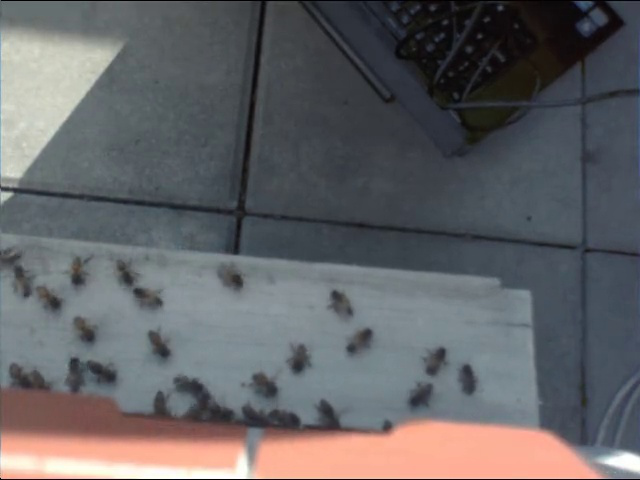

In [8]:
chosen_frames[0]

As we can see photos need to be cut - we want to analyze fields containing only bees, it would be great to have them on the uniform background.

In [7]:
frames = []
for fi in chosen_frames:
    w, h = fi.size
    frames.append(fi.crop((0, 240, 500, h-50)))

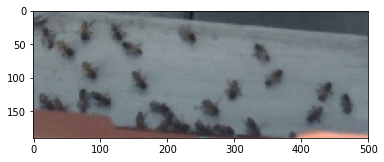

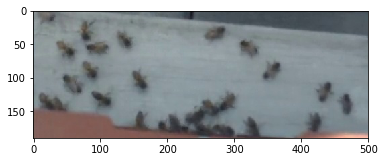

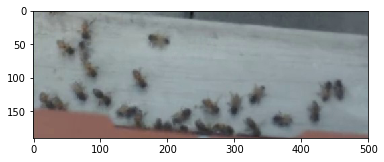

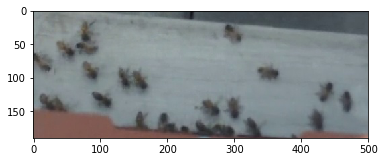

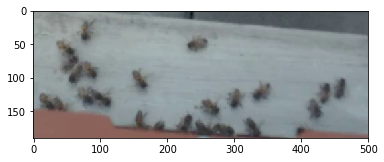

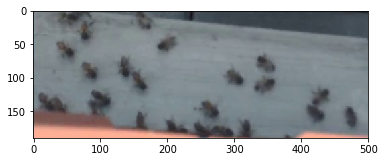

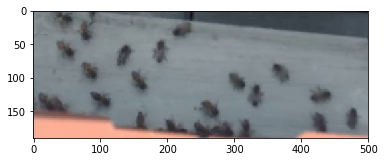

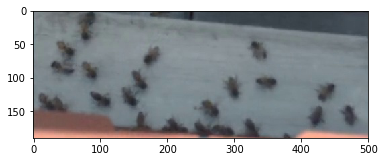

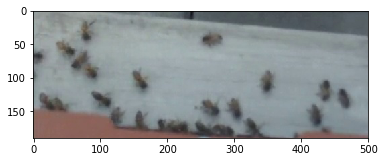

In [8]:
for f in frames:
    plt.imshow(f)
    plt.show()

*frames* list contains cropped images, ready to be analyzed.

Let us focus on the first image and perform binary segmentation.

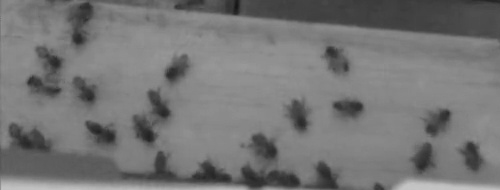

In [66]:
bees = frames[7]
gray = bees.convert('L') 
gray

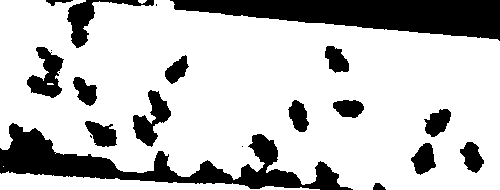

In [67]:
bw = gray.point(lambda x: 0 if x < 100 else 255, '1')
bw

In [68]:
arr = 1 - np.array(bw)

In [69]:
labels = measure.label(arr) # this array consists of labels telling us the segment which pixel belongs to
print(labels.max())

21


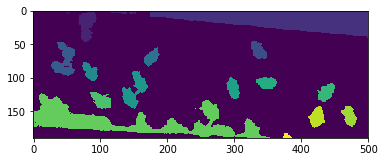

In [70]:
regions = measure.label(arr) * 30
x = regions * arr
plt.imshow(x)

Now we calculate the "volumes" of found objects. Then we will be able to select valid objects having reasonable sizes.

In [71]:
volumes = []
labels = measure.label(arr)
for label in np.unique(labels):
    volume = 0
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i,j] == label:
                volume += 1
    volumes.append((label, volume))

In [72]:
volumes

[(0, 72456),
 (1, 75),
 (2, 1040),
 (3, 8084),
 (4, 2),
 (5, 438),
 (6, 982),
 (7, 1),
 (8, 383),
 (9, 1),
 (10, 424),
 (11, 976),
 (12, 440),
 (13, 420),
 (14, 482),
 (15, 537),
 (16, 7226),
 (17, 4),
 (18, 454),
 (19, 509),
 (20, 1),
 (21, 65)]

We can observe that:
1. There are three big fields - surely they create image background (first image below)
2. There are some small fields (second image below)
3. Segments having volume in (200, 1000) interval are likely to be bees.

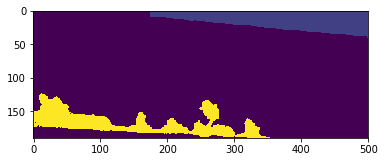

In [73]:
# Duże obiekty
labels_big = [0, 3, 16]

big_objects = np.zeros(arr.shape)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j] in labels_big:
            big_objects[i,j] = labels[i,j]

plt.imshow(big_objects)

In [60]:
# We can see three fields representing foreground elements.

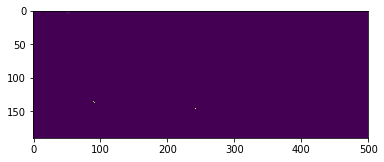

In [74]:
# Small objects

labels_small = [1, 4, 7, 9, 17, 20]

small_objects = np.zeros(arr.shape)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j] in labels_small:
            small_objects[i,j] = labels[i,j]

plt.imshow(small_objects)

In [75]:
# Normal objects

labels_normal = [item for item in range(len(volumes)) if item not in labels_small and item not in labels_big]

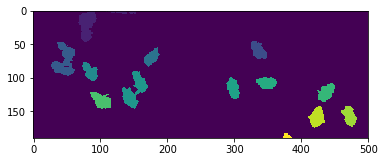

In [76]:
normal_objects = np.zeros(arr.shape)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        if labels[i,j] in labels_normal:
            normal_objects[i,j] = labels[i,j] * 20 # just to make them distinguished

plt.imshow(normal_objects)

In [77]:
len(labels_normal)

13

In [78]:
# As we can see some pairs of bees have been counted as one object.

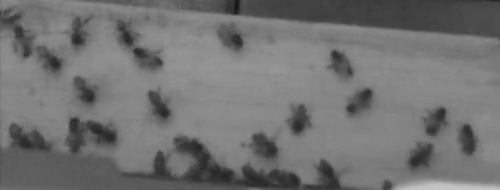

In [29]:
gray